In [14]:
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer, models
#from torch import nn
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,accuracy_score,f1_score,confusion_matrix

#https://www.kaggle.com/code/ishaaaaan/humordetect
##cite notebook for embedding and sentence transformer pre processing

AttributeError: partially initialized module 'torch' from 'c:\Users\sound\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\__init__.py' has no attribute 'library' (most likely due to a circular import)

In [5]:
with open('X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

with open('X_test.pickle', 'rb') as f:
    X_test = pickle.load(f)

with open('y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

with open('y_test.pickle', 'rb') as f:
    y_test = pickle.load(f)

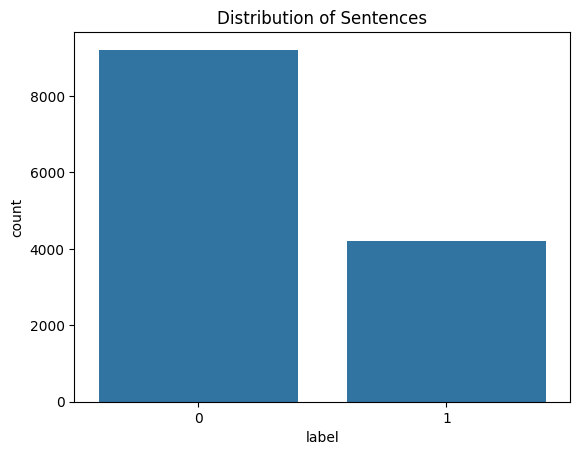

In [6]:
d = {'text' : X_train , 'label' : y_train}
train = pd.DataFrame(data = d)
sns.countplot(x='label',data=train)
plt.title('Distribution of Sentences')
plt.show()

<Axes: xlabel='label', ylabel='length'>

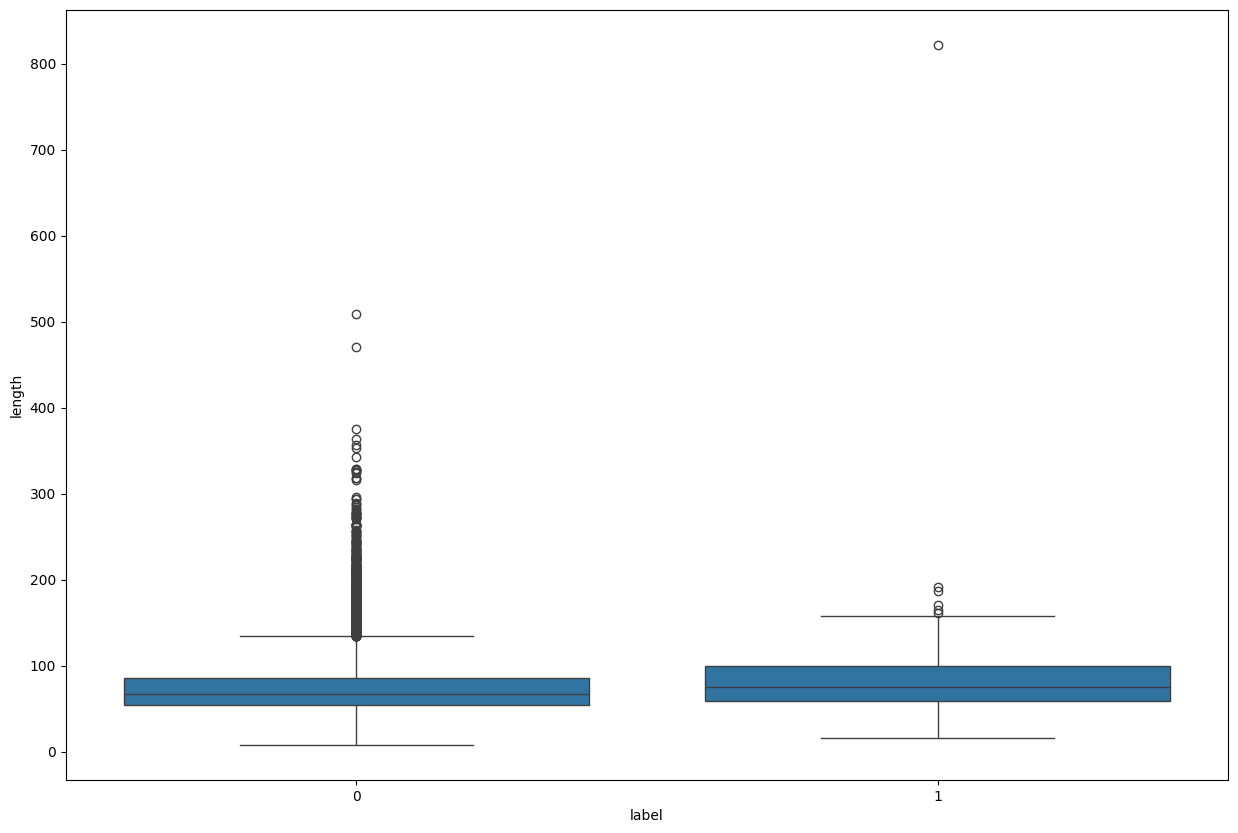

In [7]:
plt.figure(figsize=(15,10))
train['length'] = train.text.apply(lambda x: len(x))
sns.boxplot(x='label',y='length',data=train)

In [8]:
#removing instances with less than 30 and more than 140 chars in training set

print(len(train))
df = train[(train.length >= 30) & (train.length <= 140)]
df = df.reset_index()
print (len(df))

13409
12147


3355
3056


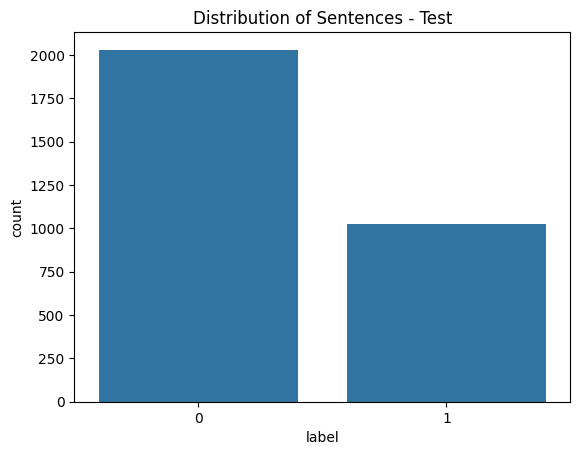

In [9]:
#removing instances with less than 30 and more than 140 chars in test set
testdf = pd.DataFrame()
testdf['text'] = X_test
testdf['label'] = y_test

print(len(testdf))
testdf['length'] = testdf['text'].str.len()
test = testdf[(testdf['length'] >= 30) & (testdf['length'] <= 140)]
test = test.reset_index(drop=True)
print(len(test))


# Looking at Test Sentences Distribution
sns.countplot(x='label',data=test)
plt.title('Distribution of Sentences - Test')
plt.show()

In [10]:
#loads BERT base model from hugging face - sets maximum length to 200 tokens
#pools token embeddings from BERT into a single fixed sized sentence vector
#adds a dense fully connected layer on top of sentence embeddings. uses tanh as activation function
#then combines all these into a sentence transformer

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=200) 
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=200, activation_function=nn.Tanh())

bert_model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])
bert_model.save("bert_joke_model")

NameError: name 'models' is not defined

In [8]:
jks = df.text[df.label == 1]
njks = df.text[df.label == 0]

# Deriving the Sentence Embeddings from our model
jokes = bert_model.encode(jks.tolist())
njokes = bert_model.encode(njks.tolist())

# A Huge matrix of Sentence Embeddings
sentences = np.concatenate((jokes,njokes),axis=0)

#Creating the labels
a = np.ones((len(df[df.label == 1]),))
b = np.zeros((len(df[df.label == 0]),))
labels = np.concatenate((a,b),axis=0)

In [ ]:
tests = bert_model.encode(test.text)

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import joblib  # for saving models


X_train, X_valid, y_train, y_valid = train_test_split(sentences, labels, test_size=0.4, random_state=42)

# Calculate threshold for probability-based classifiers
threshold = 0.5 #np.sum(1 * (y_train == 1)) / len(y_train)

# Classifiers to use
models = {
    "NeuralNet": MLPClassifier(alpha=1, max_iter=1000),
    "LogisticRegression": LogisticRegression(class_weight='balanced')
}

NameError: name 'sentences' is not defined

In [32]:
# DataFrames to store results and predictions
Y_pred_valid = pd.DataFrame({'Class_true': y_valid})
Y_results_valid = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'F1_score', 'Accuracy', 'Specificity', 'Sensitivity'])

In [33]:
for name, clf in models.items():
    clf.fit(X_train, y_train)

    # Predict
    if hasattr(clf, "predict_proba"):
        y_pred = 1 * (clf.predict_proba(X_valid)[:, 1] > threshold)
    else:
        y_pred = clf.predict(X_valid)

    Y_pred_valid[name] = y_pred

    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    tn += 1; fp += 1; fn += 1; tp += 1  # Smoothing to avoid divide-by-zero

    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    Y_results_valid = pd.concat([Y_results_valid, pd.DataFrame([{
    'Classifier': name,
    'Precision': precision,
    'Recall': recall,
    'F1_score': f1,
    'Accuracy': accuracy,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}])], ignore_index=True)

    # Save model
    joblib.dump(clf, f"{name}_model.pkl")

    print(f"Finished training and saving model: {name}")

Finished training and saving model: NeuralNet
Finished training and saving model: LogisticRegression


C:\Users\sound\AppData\Local\Temp\ipykernel_23164\1164328827.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Y_results_valid = pd.concat([Y_results_valid, pd.DataFrame([{


In [34]:
# Optional: view results
print(Y_results_valid)

           Classifier  Precision    Recall  F1_score  Accuracy  Specificity  \
0           NeuralNet   0.962228  0.905967  0.933251  0.955752     0.981262   
1  LogisticRegression   0.935196  0.948162  0.941634  0.959868     0.965646   

   Sensitivity  
0     0.905479  
1     0.947622  


In [13]:
# Nic trying
# Load models
nn_model = joblib.load("NeuralNet_model.pkl")
lr_model = joblib.load("LogisticRegression_model.pkl")

# Load your trained SentenceTransformer model
bert_model = SentenceTransformer("bert_joke_model")
# tests already exists as an encoding from bert model, using that
nn_preds = nn_model.predict(tests)
lr_preds = lr_model.predict(tests)

test['NN_pred'] = nn_preds
test['LR_pred'] = lr_preds
print(f"Evaluating {len(test)} examples:")
print(test[['text','label','NN_pred','LR_pred']].head(10))

NameError: name 'SentenceTransformer' is not defined

In [43]:
for name, col in [("NeuralNet", "NN_pred"), ("LogisticRegression", "LR_pred")]:
    y_true = test['label']
    y_pred = test[col]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print(f"\n=== {name} ===")
    print(f"Accuracy   : {acc:.3f}")
    print(f"Precision  : {prec:.3f}")
    print(f"Recall     : {rec:.3f}")
    print(f"F1-score   : {f1:.3f}")
    print(f"Confusion Matrix:")
    print(f"  TN: {tn:3d}   FP: {fp:3d}")
    print(f"  FN: {fn:3d}   TP: {tp:3d}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3))


=== NeuralNet ===
Accuracy   : 0.964
Precision  : 0.964
Recall     : 0.926
F1-score   : 0.945
Confusion Matrix:
  TN: 1995   FP:  35
  FN:  76   TP: 950

Classification Report:
              precision    recall  f1-score   support

           0      0.963     0.983     0.973      2030
           1      0.964     0.926     0.945      1026

    accuracy                          0.964      3056
   macro avg      0.964     0.954     0.959      3056
weighted avg      0.964     0.964     0.963      3056


=== LogisticRegression ===
Accuracy   : 0.966
Precision  : 0.932
Recall     : 0.969
F1-score   : 0.950
Confusion Matrix:
  TN: 1958   FP:  72
  FN:  32   TP: 994

Classification Report:
              precision    recall  f1-score   support

           0      0.984     0.965     0.974      2030
           1      0.932     0.969     0.950      1026

    accuracy                          0.966      3056
   macro avg      0.958     0.967     0.962      3056
weighted avg      0.967     0.966   

In [1]:
# # Load models
# nn_model = joblib.load("NeuralNet_model.pkl")
# lr_model = joblib.load("LogisticRegression_model.pkl")

# # Load your trained SentenceTransformer model
# bert_model = SentenceTransformer("bert_joke_model")

# Prepare your new input sentence(s)
test_sentences = ["A new wagon designed for LA rush hour traffic is called the Stationary wagon."]

# Use your SentenceTransformer model to encode the new sentence(s)
new_features = bert_model.encode(test_sentences)

# Make predictions
nn_preds = nn_model.predict(new_features)
lr_preds = lr_model.predict(new_features)

print("Neural Net Prediction:", nn_preds)
print("Logistic Regression Prediction:", lr_preds)


NameError: name 'bert_model' is not defined

In [39]:

# Replace 'your_file.pkl' with the path to your pickle file
with open('X_test.pickle', 'rb') as file:
    data = pickle.load(file)

# If the data is a list, you can print the first 10 items
if isinstance(data, list):
    print(data[:10])

# If the data is a dictionary, you can print the first 10 key-value pairs
elif isinstance(data, dict):
    for i, (key, value) in enumerate(data.items()):
        if i == 10:
            break
        print(f"{key}: {value}")

# If the data is something else, you can simply print a sample or its summary
else:
    print(data)


["Don't worry if you're a kleptomaniac, you can always take something for it.", 'Help the police - beat yourself up.', "There are two kinds of persons: The one that divide all people in two part, and then the other that don't.", 'Dead men are simple very cool.', 'A new wagon designed for LA rush hour traffic is called the Stationary wagon.', 'Two cheerleaders ended up married, they met by chants.', 'A doctor told the boy, "This injection won\'t hurt a bit."  That\'s an MD promise.', 'WHY DO MORONS ONLY GO TO MOVIES IN GROUPS OF 17 OR MORE? BECAUSE THE SIGN OUTSIDE STATES " UNDER SEVENTEEN NOT ADMITED! "', "Did you hear about the Scottish Kamikaze pilot? He crashed his plane in his brother's junkyard.", 'DID YOU HEAR ABOUT THE NEW BAGHDAD ROCK GROUP? NO KIDS ON THE BLOCK.']
